# Testing out the Python requests library for Codeforces API

## Useful Links
* [Random tutorial](https://realpython.com/blog/python/api-integration-in-python/)

* [Documentation](http://docs.python-requests.org/en/master/)

First import the requests library
```
import requests
```

Try with a random URL from the [codeforces api website](http://codeforces.com/api/help/methods#problemset.problems)
```
>>> r = requests.get('https://api.github.com/user', auth=('user', 'pass'))
>>> r.status_code
200
>>> r.headers['content-type']
'application/json; charset=utf8'
>>> r.encoding
'utf-8'
>>> r.text
u'{"type":"User"...'
>>> r.json()
{u'private_gists': 419, u'total_private_repos': 77, ...}
```

In [1]:
%matplotlib inline
import requests
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np

Codeforces returns data in JSON format. responses has a built-in function to convert this
```
>>> url = 'http://codeforces.com/api/problemset.problems?tags=implementation'
>>> r = requests.get(url)
>>> jdict = r.json()
>>> print jdict.keys()
['status', 'result']
```
```
>>> jdict['result'].keys()
['problems', 'problemStatistics']
```
Both of these are now lists of dictionaries 

In [2]:
url = 'http://codeforces.com/api/problemset.problems'
r = requests.get(url)

jdict = r.json()['result']
problems = jdict['problems']
stats = jdict['problemStatistics']

## Problems
some do not have a "points" field:
```
>>> problems[0].keys()
[u'index', u'name', u'tags', u'points', u'contestId', u'type']
[u'index', u'type', u'name', u'contestId', u'tags']

>>> test = problems[0].keys()
>>> print all([p.keys() == test for p in problems])
False
```

There seems to be a futher issue where not all contest problems are returned. See contests that have only 1 or two problems, ex 673. **May need to write a scraper for this. **

In [3]:
col_contestId = []
col_index = []
col_name = []
col_points = []
col_tags = []

for p in problems:
    col_contestId.append(p['contestId'])
    col_index.append(p['index'])
    col_name.append(p['name'])
    if "points" in p:
        col_points.append(p['points'])
    else:
        col_points.append(float('nan'))
    col_tags.append(p['tags'])

df_problems = pd.DataFrame({
        'contestId': col_contestId,
        'index': col_index,
        'name': col_name,
        'points': col_points,
        'tags': col_tags
    })
df_problems.index = [df_problems['contestId'],df_problems['index']]
df_problems.head(50)

contestId index                              name  points  \
contestId index                                                              
673       B            673     B                Problems for Round     750   
          A            673     A                     Bear and Game     500   
672       B            672     B                 Different is Good    1000   
          A            672     A                       Summer Camp     500   
671       E            671     E                 Organizing a Race    3000   
          D            671     D                  Roads in Yusland    2000   
          C            671     C    Ultimate Weirdness of an Array    1500   
          B            671     B                        Robin Hood    1000   
          A            671     A                 Recycling Bottles     500   
670       F            670     F                  Restore a Number    2500   
          E            670     E   Correct Bracket Sequence Editor    2000   
          D2           670    D2                  Magic Powder - 2     500   
          D1           670    D1                  Magic Powder - 1    1000   
          C            670     C                            Cinema    1000   
          B            670     B                    Game of Robots     750   
          A            670     A                          Holidays     500   
669       A            669     A         Little Artem and Presents     500   
667       B            667     B                Coat of Anticubism    1000   
          A            667     A                      Pouring Rain     500   
666       E            666     E              Forensic Examination    3000   
          D            666     D                    Chain Reaction    2000   
          C            666     C                          Codeword    2000   
          B            666     B                        World Tour    1000   
          A            666     A             Reberland Linguistics     500   
665       F            665     F                     Four Divisors     NaN   
          E            665     E               Beautiful Subarrays     NaN   
          D            665     D                     Simple Subset     NaN   
          C            665     C                    Simple Strings     NaN   
          B            665     B                          Shopping     NaN   
          A            665     A              Buses Between Cities     NaN   
664       A            664     A                   Complicated GCD     500   
663       A            663     A                             Rebus     500   
662       E            662     E            To Hack or not to Hack    2250   
          D            662     D            International Olympiad     250   
          C            662     C                      Binary Table    2250   
          B            662     B                    Graph Coloring     250   
          A            662     A                      Gambling Nim     500   
661       H            661     H                     Rotate Matrix     NaN   
          G            661     G                Hungarian Notation     NaN   
          F            661     F                Primes in Interval     NaN   
          E            661     E                Divisibility Check     NaN   
          D            661     D                Maximal Difference     NaN   
          C            661     C                         Array Sum     NaN   
          B            661     B                           Seasons     NaN   
          A            661     A             Lazy Caterer Sequence     NaN   
660       F            660     F                Bear and Bowling 4     NaN   
          E            660     E  Different Subsets For All Tuples     NaN   
          D            660     D          Number of Parallelograms     NaN   
          C            660     C                      Hard Process     NaN   
          B            660     B       

##  Playing with problem tags

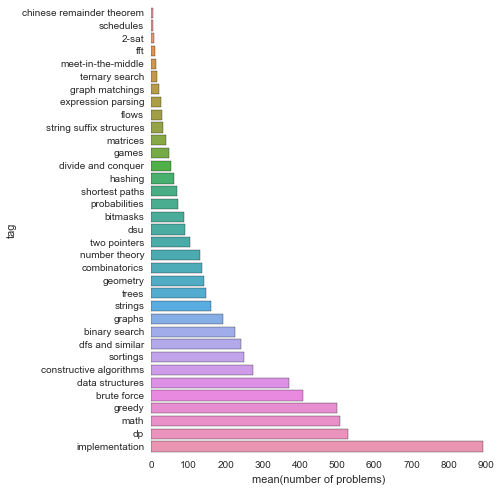

In [182]:
tags = defaultdict(int)
for p in problems:
    for t in p['tags']:
        tags[t]+=1

df_tags = pd.DataFrame({'tag':tags.keys(), 'number of problems':tags.values()})
df_tags.sort_values(by='number of problems', inplace=True)
fig=plt.figure(facecolor='white', figsize=(6, 8))
test = sns.barplot(x = 'number of problems', y='tag', data=df_tags)
test.set_axis_bgcolor('white')

## Problem Statistics
All of these have the same fields
```
>>> stats[0].keys()
[u'index', u'contestId', u'solvedCount']

>>> test = stats[0].keys()
>>> all([t.keys() == test for t in stats])
True
```
* Since simply the solvedCount is not enough to determine the actual difficulty of a question, we need to also query contests to figure out when they were actually held
* Another way to measure difficulty is to look at the % success out of all submissions. $\frac{\text{number solved}}{\text{time}}$ may not be the best measure since it does not control for the increasing popularity of codeforces.

In [209]:
#arr = [[]*len(stats) for i in range(3)]
arr = []
for s in stats:
    arr.append([s['contestId'], s['index'], s['solvedCount']])
    #arr[0].append(s['contestId'])
    #arr[1].append(s['index'])
    #arr[2].append(s['solvedCount'])
df_stats = pd.DataFrame(arr, columns=['contestId', 'index', 'solvedCount'])
df_stats.index = [df_stats.contestId, df_stats.index]
df_stats.loc[663]

,contestId,index,solvedCount
31,663,A,1402


## Contests
There may be some issues with Russian letters in the contest names
```
>>> url_contest = 'http://codeforces.com/api/contest.list?gym=false'
>>> r = requests.get(url_contest) 
>>> contests = r.json()['result']
```

```
>>> test = contests[0].keys()
[u'name',
 u'frozen',
 u'relativeTimeSeconds',
 u'durationSeconds',
 u'startTimeSeconds',
 u'phase',
 u'type',
 u'id']
>>> all([ c.keys() == test for c in contests ])
True
```

In [83]:
url_contest = 'http://codeforces.com/api/contest.list?gym=false'
r = requests.get(url_contest) #ther eare some issues with Russian letters in contest names

contests = r.json()['result']
contestDict = dict()
for c in contests:
    contestDict[c['id']] = c

In [210]:
contestDict[663]

{u'durationSeconds': 7200,
 u'frozen': False,
 u'id': 663,
 u'name': u'Codeforces Round #347 (Div. 1)',
 u'phase': u'FINISHED',
 u'relativeTimeSeconds': 2369424,
 u'startTimeSeconds': 1460824500,
 u'type': u'CF'}

###  Using datetime to figure out contest start date
```
>>> print datetime.datetime.fromtimestamp(int("1463416500")).strftime('%Y-%m-%d %H:%M:%S')
2016-05-16 12:35:00
>>> datetime.datetime.fromtimestamp(1463416500)
datetime.datetime(2016, 5, 16, 12, 35)
```

In [213]:
contestTimes = dict()
for p in problems:
    key = p['contestId']
    contestTimes[key] = datetime.datetime.fromtimestamp(int(contestDict[key]['startTimeSeconds']))


In [222]:
col_duration = []
col_frozen = []
col_id = []
col_name = []
col_phase = []
col_relativeTime = [] # second since start of contest
col_startTime = []
col_type = []
dict2df = defaultdict(list)
for c in contestDict:
    col_duration.append(contestDict[c]['durationSeconds'])
    col_frozen.append(contestDict[c]['frozen'])
    col_id.append(contestDict[c]['id'])
    col_name.append(contestDict[c]['name'])
    col_phase.append(contestDict[c]['phase'])
    col_relativeTime.append(contestDict[c]['relativeTimeSeconds']) # second since start of contest
    col_startTime.append(contestDict[c]['startTimeSeconds'])
    col_type.append(contestDict[c]['type'])
    
df_contest = pd.DataFrame({
        'duration': col_duration,
        'frozen' : col_frozen,
        'id' : col_id,
        'name' : col_name,
        'phase' : col_phase,
        'relativeTime' : col_relativeTime,
        'startTime' : col_startTime,
        'type' : col_type
    })

##  Contest submissions

In [168]:
url = "http://codeforces.com/api/contest.status?contestId=566&from=1&count=100000"
r = requests.get(url)
submissions = r.json()
submissions = submissions['result']

In [171]:
submissions[0].keys()

[u'testset',
 u'passedTestCount',
 u'author',
 u'relativeTimeSeconds',
 u'programmingLanguage',
 u'memoryConsumedBytes',
 u'timeConsumedMillis',
 u'verdict',
 u'contestId',
 u'problem',
 u'creationTimeSeconds',
 u'id']

#  Linking submissions and contests


In [212]:
df_problems['contestId']

contestId  index
673        B        673
           A        673
672        B        672
           A        672
671        E        671
           D        671
           C        671
           B        671
           A        671
670        F        670
           E        670
           D2       670
           D1       670
           C        670
           B        670
           A        670
669        A        669
667        B        667
           A        667
666        E        666
           D        666
           C        666
           B        666
           A        666
665        F        665
           E        665
           D        665
           C        665
           B        665
           A        665
                   ... 
8          A          8
7          E          7
           D          7
           C          7
           B          7
           A          7
6          E          6
           D          6
           C          6
           B          6